In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Asynchronous Python', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Docker,106.137052,3.423776,12.994308,31
SSH + SCP,112.556303,3.881252,8.823467,29
GUI Docker Container,308.391248,14.685298,26.400053,21
Linux,551.181914,17.224435,32.162993,32
"Everything is Tuberculosis, Green",407.783081,17.729699,29.258332,23
WinHex,437.343411,20.825877,31.141132,21
"The Simulacra, Dick",686.858149,36.150429,68.595120,19
Vocab,81.281440,40.640720,42.823438,2
Windows PATH Variable,1227.465625,40.915521,91.106991,30
Node.JS and React,1742.196516,56.199888,141.430720,31


# Histogram

sum of ages: ~52837.61


<Axes: >

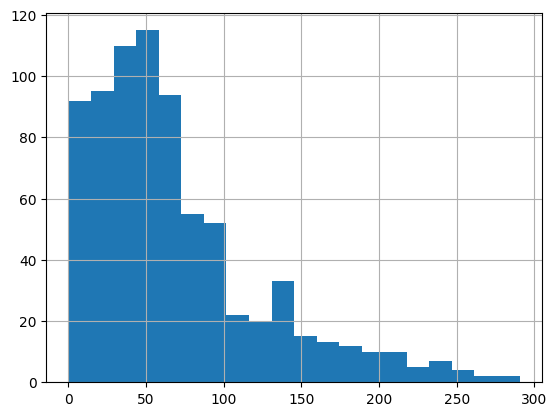

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52837.61


<Axes: >

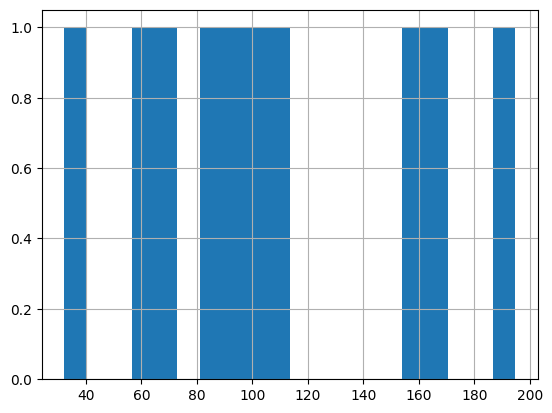

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='The Starless Crown, Rollins']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [26]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

floor dividing for n-fold
Cards found: 768
Total card age: 52837.61


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
196,Vocab,"How to Sell a Haunted House, Hendrix\nCodicil\...",1de7e737fadc28eb277f75c71abda291,42.823438,40.640720,-42.823438,81.281440,0.280455,2,0,0,-42.823438
457,Vocab,"Well of Lost Plots, Fforde\nFrontispiece\nnoun...",7310a0bde97b2c037971f66e94d4be44,38.458002,40.640720,-42.823438,81.281440,0.280455,2,1,0,-38.458002
258,Asynchronous Python,Semaphore\nA semaphore is a synchronization to...,0013ea0c17ab1cad4c6bf84571ecc821,280.639857,126.476790,-280.639857,1011.814322,0.790124,8,0,0,-280.639857
517,Asynchronous Python,Lock (Mutex)\nA lock is a synchronization prim...,2218c022e468947a8bbd7ec0626cfe1e,190.724841,126.476790,-280.639857,1011.814322,0.790124,8,1,0,-190.724841
259,Asynchronous Python,Context Switching\nContext switching is the pr...,24ba114608ca136711034849c2324122,143.455345,126.476790,-280.639857,1011.814322,0.790124,8,2,0,-143.455345
518,Asynchronous Python,async for (async iterator)\nUsed to iterate ov...,dbb74bcba577f12b06ddf83f9550d31b,133.593032,126.476790,-280.639857,1011.814322,0.790124,8,3,0,-133.593032
260,Asynchronous Python,Backpressure\nA condition in async Python wher...,5a62c5c75352420fe0f9d164e07c0d22,81.578161,126.476790,-280.639857,1011.814322,0.790124,8,4,0,-81.578161
2,"The Starless Crown, Rollins",Silage (SY-lij)\nnoun\nFermented green fodder ...,0dc54fe404993fd079f9d33d61e93d2c,194.781894,107.475123,-194.781894,1074.751228,0.615982,10,0,0,-194.781894
270,"The Starless Crown, Rollins",Curried a garment (KUR-eed)\nverb phrase\nTo t...,ccba5cbeb9a1ee7497d1d3ea6e848299,165.505975,107.475123,-194.781894,1074.751228,0.615982,10,1,0,-165.505975
529,"The Starless Crown, Rollins",Livery (LIV-er-ee)\nnoun\nA uniform or distinc...,32d60f6c174e5674cd182d190b4cdace,159.364157,107.475123,-194.781894,1074.751228,0.615982,10,2,0,-159.364157



## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(1430.924702294073)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
60,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,290.426894,90.605213,-290.426894,3714.813730,0.272446,41,0,0,-290.426894
258,Asynchronous Python,Semaphore\nA semaphore is a synchronization to...,0013ea0c17ab1cad4c6bf84571ecc821,280.639857,126.476790,-280.639857,1011.814322,0.790124,8,0,0,-280.639857
111,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,274.453957,84.744304,-274.453957,4830.425314,0.716810,57,0,0,-274.453957
54,Accounting,Allowance Method for Doubtful Accounts\nEstima...,8ab1c9af408775b6a1a9bd2d0c649d14,271.791378,91.948468,-271.791378,1471.175493,0.805763,16,0,0,-271.791378
85,Python,Q:\nHow does the os.walk() function handle per...,5b22fe84dea3190c71ab1611317e290c,258.793539,86.986913,-258.793539,6611.005402,0.446120,76,0,0,-258.793539
151,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,257.884582,76.162787,-257.884582,3046.511478,0.918733,40,0,0,-257.884582
320,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,256.877738,91.948468,-271.791378,1471.175493,0.805763,16,1,0,-256.877738
136,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,254.492651,80.566583,-254.492651,3625.496251,0.411714,45,0,0,-254.492651
350,Python,"Q:\nHow can you use tqdm with file operations,...",70d79d8d31058fa7cb312f724aa1d578,244.670668,86.986913,-258.793539,6611.005402,0.446120,76,1,0,-244.670668
48,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,240.845666,94.063864,-240.845666,1599.085680,0.445533,17,0,0,-240.845666


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.799'